
# GOCI-2 × Landsat 范围裁剪教学 Notebook

本 Notebook 将**逐步演示**：
1. 如何读取 **Landsat GeoTIFF** 的**元数据（metadata）**与**空间范围（bounds）**；
2. 如何将该范围**转换为 WGS84（经纬度）**；
3. 如何读取 **GOCI-2 L1B** 的 `latitude/longitude`；
4. 如何在 GOCI 网格上根据 Landsat 的范围**计算裁剪切片**；
5. 如何**裁剪保留指定波段（3,4,6,8,12）**并写出新的 NetCDF 文件；
6. 如何对输出进行**快速检查与验证**。

> 说明：本教程**不做重采样**，仅按范围做矩形裁剪；严格配准可在后续用 `pyresample` 完成。



## 0. 环境与依赖

需要安装：`rasterio`, `netCDF4`, `numpy`, `matplotlib`。  
下面先检查一下环境。


In [1]:

import sys, importlib

def _chk(mod):
    try:
        m = importlib.import_module(mod)
        print(f"✓ {mod} {getattr(m, '__version__', '')}")
    except Exception as e:
        print(f"✗ {mod} 未安装：{e}")

for m in ["rasterio", "netCDF4", "numpy", "matplotlib"]:
    _chk(m)
print("Python", sys.version)


✓ rasterio 1.4.3
✓ netCDF4 1.7.2
✓ numpy 2.2.4
✓ matplotlib 3.10.5
Python 3.10.16 (main, Dec 11 2024, 10:22:29) [Clang 14.0.6 ]


In [2]:
import os

# 输出当前工作路径
print("当前路径:", os.getcwd())


当前路径: /Users/zy/Python_code/My_Git/img_match/TOA_match



## 1. 路径设置（按需修改）

将以下路径改为你本地的实际位置：
- `goci_nc`：GOCI-2 L1B 输入文件（`.nc`）；
- `ref_tif`：Landsat 参考影像（多波段 TOA/辐亮度 TIF）；
- `out_nc`：输出的裁剪后 NetCDF 文件路径。


In [3]:

import os

# ======== 按需修改为你的实际路径 ========
goci_nc = r"../SR_Imagery/GK2_GOCI2_L1B_20250504_021530_LA_S007.nc"
ref_tif  = r"../SR_Imagery/LC09_L1TP_116035_20250504_20250504_02_T1/LC09_L1TP_116035_20250504_20250504_02_T1_TOA_RAD_B1-2-3-4-5.tif"
out_nc   = r"goci_subset_5bands1.nc"
keep_indices = [3, 4, 6, 8, 12]   # 1-based
# =====================================

assert os.path.exists(goci_nc), f"GOCI 文件不存在：{goci_nc}"
assert os.path.exists(ref_tif), f"参考 TIF 不存在：{ref_tif}"
print("路径检查通过。")


路径检查通过。



## 2. 读取 Landsat GeoTIFF 的 **metadata** 与 **bounds**

- `ds.bounds` 返回在 `ds.crs` 坐标系下的外接矩形范围（left, bottom, right, top）；  
- `ds.crs` 是坐标参考系；  
- `ds.transform` 是仿射变换（像元到投影坐标）；  
- `ds.width/height` 是栅格尺寸；  
- `ds.res` 是像元大小；  
- `ds.tags()` / `ds.tags(band=i)` 读取文件/波段元数据。


In [4]:

import rasterio
from pprint import pprint

with rasterio.open(ref_tif) as ds:
    print("CRS:", ds.crs)
    print("Size (width, height):", (ds.width, ds.height))
    print("Resolution (xres, yres):", ds.res)
    print("Transform:", ds.transform)
    print("Bounds (in CRS):", ds.bounds)

    print("\n[File-level tags metadata]")
    pprint(ds.tags())

    # 如果需要，查看某个波段的元数据（注意 band 索引从 1 开始）
    try:
        print("\n[Band-1 tags metadata]")
        pprint(ds.tags(1))
    except Exception as e:
        print("读取 Band-1 tags 失败：", e)


CRS: EPSG:32652
Size (width, height): (7841, 7961)
Resolution (xres, yres): (30.0, 30.0)
Transform: | 30.00, 0.00, 127485.00|
| 0.00,-30.00, 4111515.00|
| 0.00, 0.00, 1.00|
Bounds (in CRS): BoundingBox(left=127485.0, bottom=3872685.0, right=362715.0, top=4111515.0)

[File-level tags metadata]
{'AREA_OR_POINT': 'Area'}

[Band-1 tags metadata]
{}


In [5]:
with rasterio.open(ref_tif) as ds:
    print("CRS:", ds.crs)
    print("Transform:", ds.transform)
    print("Bounds (in CRS):", ds.bounds)


CRS: EPSG:32652
Transform: | 30.00, 0.00, 127485.00|
| 0.00,-30.00, 4111515.00|
| 0.00, 0.00, 1.00|
Bounds (in CRS): BoundingBox(left=127485.0, bottom=3872685.0, right=362715.0, top=4111515.0)



## 3. 将 **bounds** 转换到 WGS84（经纬度）

使用 `rasterio.warp.transform_bounds(src_crs, 'EPSG:4326', ...)`。  
`densify_pts=21` 会在边界上加密采样点，提升曲边投影下范围转换的精度。


In [8]:

from rasterio.warp import transform_bounds

with rasterio.open(ref_tif) as ds:
    b = ds.bounds
    minx, miny, maxx, maxy = transform_bounds(
        ds.crs, "EPSG:4326", b.left, b.bottom, b.right, b.top, densify_pts=21
    )
print(f"WGS84 bbox: lon[{minx:.6f}, {maxx:.6f}], lat[{miny:.6f}, {maxy:.6f}]")


WGS84 bbox: lon[124.810170, 127.495823], lat[34.928266, 37.139942]



## 4. 快速可视化 Landsat 的 WGS84 范围（矩形）

仅作为示意：使用 `matplotlib` 画出经纬度外接矩形。


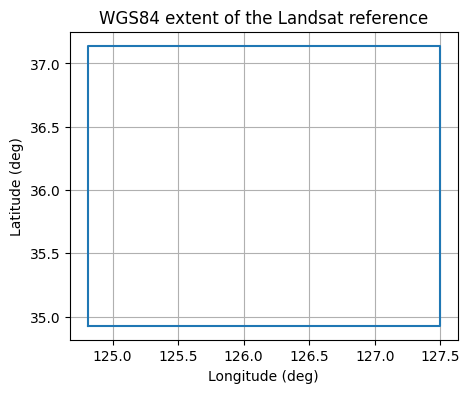

In [17]:

import matplotlib.pyplot as plt

xs = [minx, maxx, maxx, minx, minx]
ys = [miny, miny, maxy, maxy, miny]

plt.figure(figsize=(5,4))
plt.plot(xs, ys)
plt.xlabel("Longitude (deg)"); plt.ylabel("Latitude (deg)")
plt.title("WGS84 extent of the Landsat reference")
plt.grid(True)
plt.show()



## 5. 读取 GOCI-2 L1B 的 `latitude/longitude`

- GOCI L1B 中经纬度通常位于 `navigation_data/latitude` 与 `navigation_data/longitude`；  
- 这里只做**范围裁剪**，因此无需重投影。  
- 我们先检查经纬度矩阵的形状、最小/最大值。


In [ ]:

import numpy as np
from netCDF4 import Dataset

with Dataset(goci_nc, "r") as nc:
    lat = nc["navigation_data"]["latitude"][:]
    lon = nc["navigation_data"]["longitude"][:]

lat = np.asarray(lat)
lon = np.asarray(lon)
assert lat.shape == lon.shape, f"lat/lon 形状不一致：{lat.shape} vs {lon.shape}"
print("GOCI lat/lon shape:", lat.shape)
print("lat min/max:", float(np.nanmin(lat)), float(np.nanmax(lat)))
print("lon min/max:", float(np.nanmin(lon)), float(np.nanmax(lon)))


GOCI lat/lon shape: (2780, 2780)
lat min/max: 30.66546630859375 39.28562927246094
lon min/max: 121.99646759033203 130.40538024902344



## 6. 在 GOCI 网格上计算裁剪切片

思路：
1. 在经纬度网格上构造布尔掩膜 `inside`，筛选落入 Landsat 范围（WGS84）的像元；  
2. 沿行/列方向求 `any`，获得需要保留的行列索引；  
3. 取最小/最大行列索引并各扩展 1 个像元，形成半开区间 `[r0:r1), [c0:c1)`。


In [21]:

def compute_slice_from_bbox(lat, lon, minx, miny, maxx, maxy):
    inside = (lon >= minx) & (lon <= maxx) & (lat >= miny) & (lat <= maxy)
    if not np.any(inside):
        raise RuntimeError("裁剪失败：参考范围与 GOCI 网格不相交。")
    rows = np.any(inside, axis=1)
    cols = np.any(inside, axis=0)
    r_idx = np.where(rows)[0]
    c_idx = np.where(cols)[0]
    r0, r1 = int(r_idx.min()), int(r_idx.max()) + 1
    c0, c1 = int(c_idx.min()), int(c_idx.max()) + 1
    return r0, r1, c0, c1

r0, r1, c0, c1 = compute_slice_from_bbox(lat, lon, minx, miny, maxx, maxy)
print(f"裁剪切片 rows[{r0}:{r1}] cols[{c0}:{c1}] -> 形状 {(r1-r0, c1-c0)}")


裁剪切片 rows[640:1346] cols[852:1808] -> 形状 (706, 956)



## 7. 指定要保留的 GOCI 波段

GOCI-2 L1B 中常见辐亮度变量：
`L_TOA_380, L_TOA_412, L_TOA_443, L_TOA_490, L_TOA_510, L_TOA_555,
 L_TOA_620, L_TOA_660, L_TOA_680, L_TOA_709, L_TOA_745, L_TOA_865`。

这里保留 **3,4,6,8,12**（1-based），即：443, 490, 555, 660, 865。


In [22]:

BAND_INDEX_TO_NAME = {
    1: "L_TOA_380",
    2: "L_TOA_412",
    3: "L_TOA_443",
    4: "L_TOA_490",
    5: "L_TOA_510",
    6: "L_TOA_555",
    7: "L_TOA_620",
    8: "L_TOA_660",
    9: "L_TOA_680",
    10:"L_TOA_709",
    11:"L_TOA_745",
    12:"L_TOA_865",
}

# 校验 keep_indices 合法性
for k in keep_indices:
    assert k in BAND_INDEX_TO_NAME, f"非法波段索引：{k}"
print("将保留的变量：", [BAND_INDEX_TO_NAME[i] for i in keep_indices])


将保留的变量： ['L_TOA_443', 'L_TOA_490', 'L_TOA_555', 'L_TOA_660', 'L_TOA_865']



## 8. 裁剪波段数据（仅范围，不重采样）

- 读取 `geophysical_data/{L_TOA_*}`；
- 应用切片 `[r0:r1, c0:c1]`；
- 用变量自身的 `_FillValue` 将无效值暂记为 `NaN`（便于统计）；
- 暂存在内存中，准备写出。


In [ ]:

band_vars = {}
band_attrs = {}
fillvals = {}

with Dataset(goci_nc, "r") as nc:
    geo_grp = nc["geophysical_data"]
    for idx in keep_indices:
        vname = BAND_INDEX_TO_NAME[idx]
        if vname not in geo_grp.variables:
            raise KeyError(f"缺少变量 geophysical_data/{vname}")
        var = geo_grp[vname]
        attrs = {att: getattr(var, att) for att in var.ncattrs()}
        fv = attrs.get("_FillValue", None)

        data_sub = var[r0:r1, c0:c1]
        if fv is not None:
            data_sub = np.where(data_sub == fv, np.nan, data_sub)

        band_vars[vname] = data_sub.astype("float32", copy=False)
        band_attrs[vname] = attrs
        fillvals[vname] = fv

lat_sub = lat[r0:r1, c0:c1].astype("float32", copy=False)
lon_sub = lon[r0:r1, c0:c1].astype("float32", copy=False)

print("裁剪完成。裁剪后形状：", lat_sub.shape)
for k, v in band_vars.items():
    print(k, "min/max (忽略NaN):", float(np.nanmin(v)), float(np.nanmax(v)))



## 9. 写出裁剪后的 NetCDF

- 创建维度 `y, x`；  
- 写入 `latitude/longitude`；  
- 写入各 `L_TOA_*` 变量，并尽量保留原始属性（不覆盖 `_FillValue`）；  
- 默认单位若缺失，补充为 `W m-2 sr-1 um-1`。


In [ ]:

# 写出 NC
os.makedirs(os.path.dirname(os.path.abspath(out_nc)), exist_ok=True)

from netCDF4 import Dataset as _DS

with _DS(out_nc, "w", format="NETCDF4") as dst:
    ny, nx = lat_sub.shape
    dst.createDimension("y", ny)
    dst.createDimension("x", nx)

    # 全局属性
    dst.source  = "Cropped from GOCI-2 L1B by Landsat extent"
    dst.history = "created by tutorial notebook (range crop only, no resampling)"
    dst.note    = "Rectangle crop in WGS84 bbox; for strict co-registration use pyresample."
    dst.keep_band_indices = ",".join(map(str, keep_indices))
    dst.keep_band_names   = ",".join([BAND_INDEX_TO_NAME[i] for i in keep_indices])

    # lat/lon
    v_lat = dst.createVariable("latitude",  "f4", ("y","x"), zlib=True, complevel=4)
    v_lon = dst.createVariable("longitude", "f4", ("y","x"), zlib=True, complevel=4)
    v_lat.long_name = "latitude";  v_lat.units = "degrees_north"
    v_lon.long_name = "longitude"; v_lon.units = "degrees_east"
    v_lat[:] = lat_sub
    v_lon[:] = lon_sub

    # 波段
    for vname, data_sub in band_vars.items():
        fv = fillvals[vname]
        if fv is None:
            fv = -999.0
        out = np.nan_to_num(data_sub, nan=fv).astype("f4", copy=False)

        v = dst.createVariable(vname, "f4", ("y","x"), zlib=True, complevel=4, fill_value=fv)

        # 恢复原属性（避免覆盖 _FillValue）
        for k, val in band_attrs[vname].items():
            if k == "_FillValue":
                continue
            try:
                setattr(v, k, val)
            except Exception:
                pass

        if not hasattr(v, "units"):
            v.units = "W m-2 sr-1 um-1"
        v[:] = out

print(f"[OK] 写出：{out_nc}")



## 10. 结果验证（可选）

快速打开输出文件，检查：变量清单、维度、统计量是否合理。


In [ ]:

from netCDF4 import Dataset as DS
import numpy as np

with DS(out_nc, "r") as nc:
    print("维度：", {k: len(v) for k, v in nc.dimensions.items()})
    print("变量：", list(nc.variables.keys()))
    for name in nc.variables:
        if name in ["latitude", "longitude"]:
            arr = nc[name][:]
            print(name, "shape:", arr.shape, "min/max:", float(np.nanmin(arr)), float(np.nanmax(arr)))
    for name in nc.variables:
        if name.startswith("L_TOA_"):
            arr = nc[name][:]
            # 读取 _FillValue（若存在）并屏蔽
            fv = getattr(nc[name], "_FillValue", None)
            if fv is not None:
                arr = np.where(arr == fv, np.nan, arr)
            print(name, "min/max (忽略NaN):", float(np.nanmin(arr)), float(np.nanmax(arr)))



## 备注

- 本流程只 **按经纬度矩形范围裁剪**，不执行重采样；因此裁剪后的像元网格仍是 GOCI 原网格。  
- 若需要将 GOCI 数据拟合到 Landsat 像元中心进行严格配准与插值，请使用 `pyresample`：
  - 构造 `SwathDefinition`（由 `lat/lon` 构成）和 `AreaDefinition`（Landsat 投影与栅格）；
  - 使用 `kd_tree.resample_nearest` 或 `resample_gauss` 等方法进行重采样。
